# Import Necessary Libraries

In [1]:
import os
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf

from IPython.core.interactiveshell import InteractiveShell #show all work
InteractiveShell.ast_node_interactivity = "all" #works with Interactiveshell to display work for every code block

Using TensorFlow backend.
C:\Users\Randy\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#TF Test
hello = tf.constant('Hello, Tensorflow!')
sess = tf.Session()
print(sess.run(hello))

b'Hello, Tensorflow!'


# Import and Check Data

In [3]:
#dataset was already combined at www.kaggle.com in two csv files
fmnist_train = pd.read_csv(r"C:\Users\Randy\Dropbox\Syracuse\iSchool\IST718\Homework\Labs\Lab3\data\fashion-mnist_train.csv")
fmnist_test = pd.read_csv(r"C:\Users\Randy\Dropbox\Syracuse\iSchool\IST718\Homework\Labs\Lab3\data\fashion-mnist_test.csv")

fmnist_train.shape
fmnist_test.shape

(60000, 785)

(10000, 785)

# Visualize the Data

In [4]:
#visualize number of each article of clothing to check distribution
label = {0:'t_shirt', 1:'trouser', 2:'pullover', 3:'dress', 4:'coat', 5:'sandal', 6:'shirt', 7:'sneaker', 8:'bag',
         9:'ankle_boot'} 

#create a version of fmnist_train to visualize data
viz_fmnist = fmnist_train.copy()

#assign labels to clothing types
viz_fmnist['label'] = viz_fmnist['label'].map(label)

viz_fmnist.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,pullover,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ankle_boot,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,shirt,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,t_shirt,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,dress,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#change values greater than 0 to 1 for easy counting of pixels
viz_fmnist.iloc[:, 1:784] = np.where(viz_fmnist.iloc[:, 1:784] > 0, 1, 0)

#get pixel count per row
viz_fmnist['pixel_sum'] = viz_fmnist.iloc[:, 1:784].sum(axis = 1)

#remove unwanted data
viz_fmnist = viz_fmnist[['label', 'pixel_sum']]

viz_fmnist.head(5)

,label,pixel_sum
0,pullover,478
1,ankle_boot,340
2,shirt,504
3,t_shirt,481
4,dress,360


Text(0.5,1,'Count of Article Types')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

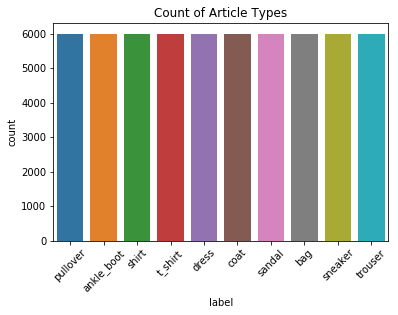

In [6]:
#view count of each type of article in a histogram
sns.countplot(viz_fmnist['label']).set_title('Count of Article Types')
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

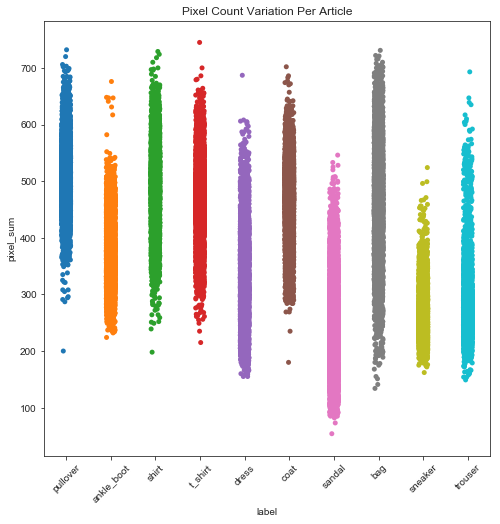

In [7]:
#variance of pixels used per type of clothing
sns.set_style('ticks')
fig, ax = plt.subplots()

fig.set_size_inches(8, 8)

ax = sns.stripplot(x="label", y="pixel_sum", hue="label", data=viz_fmnist,
                   jitter = True).set_title('Pixel Count Variation Per Article')

plt.legend().set_visible(False)
plt.xticks(rotation = 45)
plt.show()

In [8]:
#function to easily view any item in the training set
def fashion_viz(row_nums):
    
    #separate labels from pixels to visualize the data
    pixels = fmnist_train.iloc[:, 1:]
    labels = fmnist_train.iloc[:, 0:1]
       
    pixel = pixels.loc[row_nums]
    pixel = np.array(pixel, dtype = 'int32')
    pixel = pixel.reshape((28,28))
     
    plt.imshow(pixel)
    plt.show
    

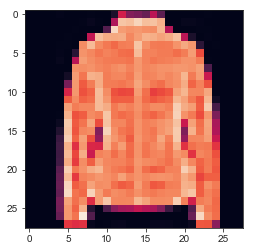

In [9]:
#show some visualization of the fashion mnist data.  changing the number in parentheses shows different articles of clothing.
fashion_viz(25)

# Add Feature Data

In [10]:
label = {0:'t_shirt', 1:'trouser', 2:'pullover', 3:'dress', 4:'coat', 5:'sandal', 6:'shirt', 7:'sneaker', 8:'bag',
         9:'ankle_boot'} 

#add a min and max pixel count column to the training and test data above to help prediction
min_max_dict = {0: {'0':{'min_pixels':200, 'max_pixels':710}},
                1: {'1':{'min_pixels':150, 'max_pixels':650}},
                2: {'2':{'min_pixels':200, 'max_pixels':710}},
                3: {'3':{'min_pixels':300, 'max_pixels':700}},
                4: {'4':{'min_pixels':280, 'max_pixels':700}},
                5: {'5':{'min_pixels':95,  'max_pixels':550}},
                6: {'6':{'min_pixels':250, 'max_pixels':720}},
                7: {'7':{'min_pixels':180, 'max_pixels':500}},
                8: {'8':{'min_pixels':150, 'max_pixels':710}},
                9: {'9':{'min_pixels':220, 'max_pixels':600}}}
                 

min_max_pixels = pd.DataFrame.from_dict({(i,j): min_max_dict[i][j] 
                           for i in min_max_dict.keys() 
                           for j in min_max_dict[i].keys()},
                       orient='index')
min_max_pixels.index = [0,1,2,3,4,5,6,7,8,9]

In [11]:
#add the new feature data to the training and test sets
rf_train = pd.merge(fmnist_train.copy(), min_max_pixels, how='left', left_on='label', right_on=min_max_pixels.index)
rf_test = pd.merge(fmnist_test.copy(), min_max_pixels, how='left', left_on='label', right_on=min_max_pixels.index)

# Build Train and Test DFs for Random Forest

In [12]:
#separate labels and pixels to build a training and validation set for the random forest (RF) model.
labels = rf_train.iloc[:, 0]
pixels = rf_train.iloc[:, 1:]

#set up training and validate data for a random forest model
rfx_train, rfx_validate, rfy_train, rfy_validate= train_test_split(pixels, labels, random_state = 1776, test_size=0.2)

In [13]:
print('rfx_train shape: {}'.format(rfx_train.shape))
print('rfx_validate shape: {}'.format(rfx_validate.shape))

rfx_train shape: (48000, 786)
rfx_validate shape: (12000, 786)


# Random Forest Model (RF)

In [14]:
%%time

#build a random forest model to attempt to predict image categories
rf_model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=100,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

rf_model.fit(rfx_train, rfy_train)

Wall time: 10.8 s


In [15]:
#validate the RF model
rf_prediction = rf_model.predict(rfx_validate)
rf_model.score(rfx_validate, rfy_validate)

0.94175

In [16]:
#run rf model against test data
rf_test_pred = rf_model.predict(rf_test.iloc[:,1:])
rf_model.score(rf_test.iloc[:,1:], rf_test.iloc[:,0])

0.9448

# Convolution Neural Network (CNN)

In [17]:
#turn the data back into an array and group by x and y axes to build a convolution neural network (CNN).

train_array = np.array(fmnist_train, dtype = 'float32')
test_array = np.array(fmnist_test, dtype = 'float32')

#divide columns 1-784 by 255 to get a percentage value for color.
x_train = train_array[:, 1:]/255
y_train = train_array[:, 0]

x_test = test_array[:, 1:]/255
y_test = test_array[:, 0]

In [18]:
#set up a training split from the training data to predict how well the training data classifies each row.
x_train, x_validate, y_train, y_validate = train_test_split(
    x_train, y_train, test_size = 0.2, random_state = 1776)

In [19]:
#reshape the CNN data to easily plug in to the model
img_rows = 28
img_cols = 28
batch_size = 600
img_shape = (img_rows, img_cols, 1)

x_train = x_train.reshape(x_train.shape[0], *img_shape)
x_test = x_test.reshape(x_test.shape[0], *img_shape)
x_validate = x_validate.reshape(x_validate.shape[0], *img_shape)

print('x_train shape: {}'.format(x_train.shape))
print('x_test shape: {}'.format(x_test.shape))
print('x_validate shape: {}'.format(x_validate.shape))

x_train shape: (48000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
x_validate shape: (12000, 28, 28, 1)


In [20]:
#build a convolution neural network
cnn_model = Sequential([
    Conv2D(filters=32, kernel_size = 2, activation = 'relu', input_shape = img_shape),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    
    Flatten(),
    Dense(32, activation = 'relu'),
    Dense(10, activation = 'softmax')
])

In [21]:
#compile the model 
cnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(lr=0.01),
    metrics=['accuracy']
)

In [22]:
%%time

cnn_model.fit(
    x_train, y_train, batch_size = batch_size, 
    epochs = 10, verbose = 1, 
    validation_data = (x_validate, y_validate),
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 11s 226us/step - loss: 0.6184 - acc: 0.7798 - val_loss: 0.3921 - val_acc: 0.8599
Epoch 2/10
48000/48000 [==============================] - 5s 109us/step - loss: 0.3406 - acc: 0.8780 - val_loss: 0.3379 - val_acc: 0.8795
Epoch 3/10
48000/48000 [==============================] - 5s 109us/step - loss: 0.2956 - acc: 0.8939 - val_loss: 0.3323 - val_acc: 0.8805
Epoch 4/10
48000/48000 [==============================] - 5s 111us/step - loss: 0.2758 - acc: 0.8999 - val_loss: 0.3100 - val_acc: 0.8892
Epoch 5/10
48000/48000 [==============================] - 5s 110us/step - loss: 0.2603 - acc: 0.9042 - val_loss: 0.2981 - val_acc: 0.8936
Epoch 6/10
48000/48000 [==============================] - 5s 109us/step - loss: 0.2398 - acc: 0.9129 - val_loss: 0.2919 - val_acc: 0.8999
Epoch 7/10
48000/48000 [==============================] - 5s 113us/step - loss: 0.2283 - acc: 0.9160 - val_loss: 0.3145 -

In [23]:
score = cnn_model.evaluate(x_test, y_test, verbose = 0)
print('test loss {:4f}'.format(score[0]))
print('test acc: {:4f}'.format(score[1]))

test loss 0.279498
test acc: 0.905100
